In [8]:

import mlflow

import os

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
# import bokeh as bh

from datetime import datetime
import taxi_driver.taxi_driver as td


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score

mlflow.sklearn.autolog()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error


from sklearn.dummy import DummyRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



# 📋 Evaluation Function
def eval_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<20} | MSE: {mse:.4f} | R²: {r2:.4f}")

mlflow.set_tracking_uri("http://localhost:5000")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Init Read and cleaning

In [3]:
#setting some much needed paths 

dataPath = os.path.join("data")
csvPath  = os.path.join(dataPath,"CSV")
shpPath  = os.path.join(dataPath,"SHP")

outputPath = os.path.join("outputs")
imagePath = os.path.join(outputPath,"images")



In [4]:
zoneShpPath = os.path.join(shpPath,"taxi_zones.shp")

#combine in one
march_path = os.path.join(dataPath,"yellow_tripdata_2024-03.parquet")
june_path = os.path.join(dataPath,"yellow_tripdata_2024-06.parquet")
nov_path = os.path.join(dataPath,"yellow_tripdata_2024-11.parquet")

taxi_df=td.Taxidf([march_path,june_path,nov_path],
                  sample_fraction=0.3,
                  taxi_zones_shp_path=zoneShpPath)
taxi_df.convert_dates()


/home/itoumpalidis/work/git/nyc_taxi_tips/taxi_driver/taxi_driver.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.taxi_data=pd.concat([self.taxi_data,temp_df])


Sampling the main dataset by selecting only the trips payed with card, tip amount, trip distance and fare amount
that are non negative.

## Data Processing / Feature Engineering

In [ ]:
clean_df=taxi_df.taxi_data.copy()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,do_day,do_hour,pu_date,do_date,congestion_surcharge,Airport_fee,pu_month,do_month,pu_year,do_year
3327050,2,2024-03-14 21:10:53,2024-03-14 21:27:37,NaN,3.40,NaN,None,125,162,0,...,3,21,2024-03-14,2024-03-14,NaN,NaN,3,3,2024,2024
2661989,2,2024-03-27 00:35:48,2024-03-27 00:41:18,1.0,1.30,1.0,N,142,68,1,...,2,0,2024-03-27,2024-03-27,2.5,0.00,3,3,2024,2024
1141272,2,2024-03-12 09:09:32,2024-03-12 09:20:47,5.0,0.99,1.0,N,161,164,1,...,1,9,2024-03-12,2024-03-12,2.5,0.00,3,3,2024,2024
1333747,1,2024-03-13 23:50:22,2024-03-14 00:03:15,1.0,2.40,1.0,N,48,141,1,...,3,0,2024-03-13,2024-03-14,2.5,0.00,3,3,2024,2024
2950867,2,2024-03-29 19:01:49,2024-03-29 19:10:04,1.0,0.72,1.0,N,100,230,1,...,4,19,2024-03-29,2024-03-29,2.5,0.00,3,3,2024,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825172,2,2024-11-17 01:51:18,2024-11-17 01:58:44,1.0,0.69,1.0,N,107,137,1,...,6,1,2024-11-17,2024-11-17,2.5,0.00,11,11,2024,2024
984534,1,2024-11-09 20:48:16,2024-11-09 21:06:58,2.0,2.70,1.0,N,234,141,1,...,5,21,2024-11-09,2024-11-09,2.5,0.00,11,11,2024,2024
2756416,2,2024-11-25 11:08:04,2024-11-25 11:45:08,1.0,8.63,1.0,N,138,230,1,...,0,11,2024-11-25,2024-11-25,2.5,1.75,11,11,2024,2024
2007153,2,2024-11-18 21:20:49,2024-11-18 21:30:45,1.0,2.17,1.0,N,113,48,4,...,0,21,2024-11-18,2024-11-18,-2.5,0.00,11,11,2024,2024


In [44]:
import holidays
us_holidays = holidays.UnitedStates()
grouped_date=taxi_df.grouped_date()
holidays=[datetime.strptime(i,"%Y-%m-%d") in grouped_date for i in list (grouped_date.index)] 

if(not True in holidays):
    print("there are no holidays in the data set")
else:
    print("check for the holidays")

there are no holidays in the data set


Introduce some new features that might help on the modelling

In [9]:
clean_df['is_weekend'] = clean_df['pu_day'].isin([5, 6]).astype(int)
clean_df['is_night'] = clean_df['pu_hour'].apply(lambda h: 1 if h < 6 or h > 21 else 0)


clean_df['dollar_per_mile']=clean_df['fare_amount']/clean_df['trip_distance']
clean_df['tip_to_fare']=clean_df['tip_amount']/clean_df['fare_amount']
clean_df['duration_s']=(clean_df['tpep_dropoff_datetime']-clean_df['tpep_pickup_datetime']).apply(lambda x:x.seconds)
clean_df['speed_kpi']=clean_df['trip_distance']/clean_df['duration_s']

mod_tip = clean_df['tip_amount']%1
clean_df['set_tip_amount_flag']=mod_tip.apply(lambda x:0 if x==0 else 1)

clean_df['Airport_flag']=clean_df['Airport_fee'].apply(lambda x: 0 if x==0 else 1)
clean_df['congestion_surcharge_flag']=clean_df['congestion_surcharge'].apply(lambda x: 0 if x==0 else 1)
clean_df['mta_tax_flag']=clean_df['mta_tax'].apply(lambda x: 0 if x==0 else 1)

filter out outliers, negative values etc. 

In [10]:
#select for now only one vendor id
clean_df = clean_df[clean_df['VendorID']==2]


#will keep only the payment checks
clean_df = clean_df[clean_df['payment_type']==1]

# I will create a sample of only the non_negative
clean_df= clean_df[clean_df['tip_amount']>0]
clean_df= clean_df[clean_df['trip_distance']>0]

# duration >0
clean_df = clean_df[clean_df['duration_s']>0]


#controlling the value between >0 
clean_df=clean_df.loc[(clean_df['fare_amount']>0)]


# tip <100% of the price of the ride
clean_df=clean_df[clean_df['tip_to_fare']<1]

clean_df = clean_df.dropna()

In [29]:
clean_df = clean_df.query('pu_year==2024 and pu_month in [3,6,11] and do_year==2024 and do_month in [3,6,11]')

In [10]:

# encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
# spatial_array = encoder.fit_transform(clean_df[['PULocationID','DOLocationID']])


In [30]:
# fileName = "clean_sample.csv"
# filePath = os.path.join(csvPath,fileName)
clean_df.to_parquet('./data/clean_sample.parquet')


In [64]:
df['pu_date'] = df['pu_date'].apply(lambda x : pd.to_datetime(x))

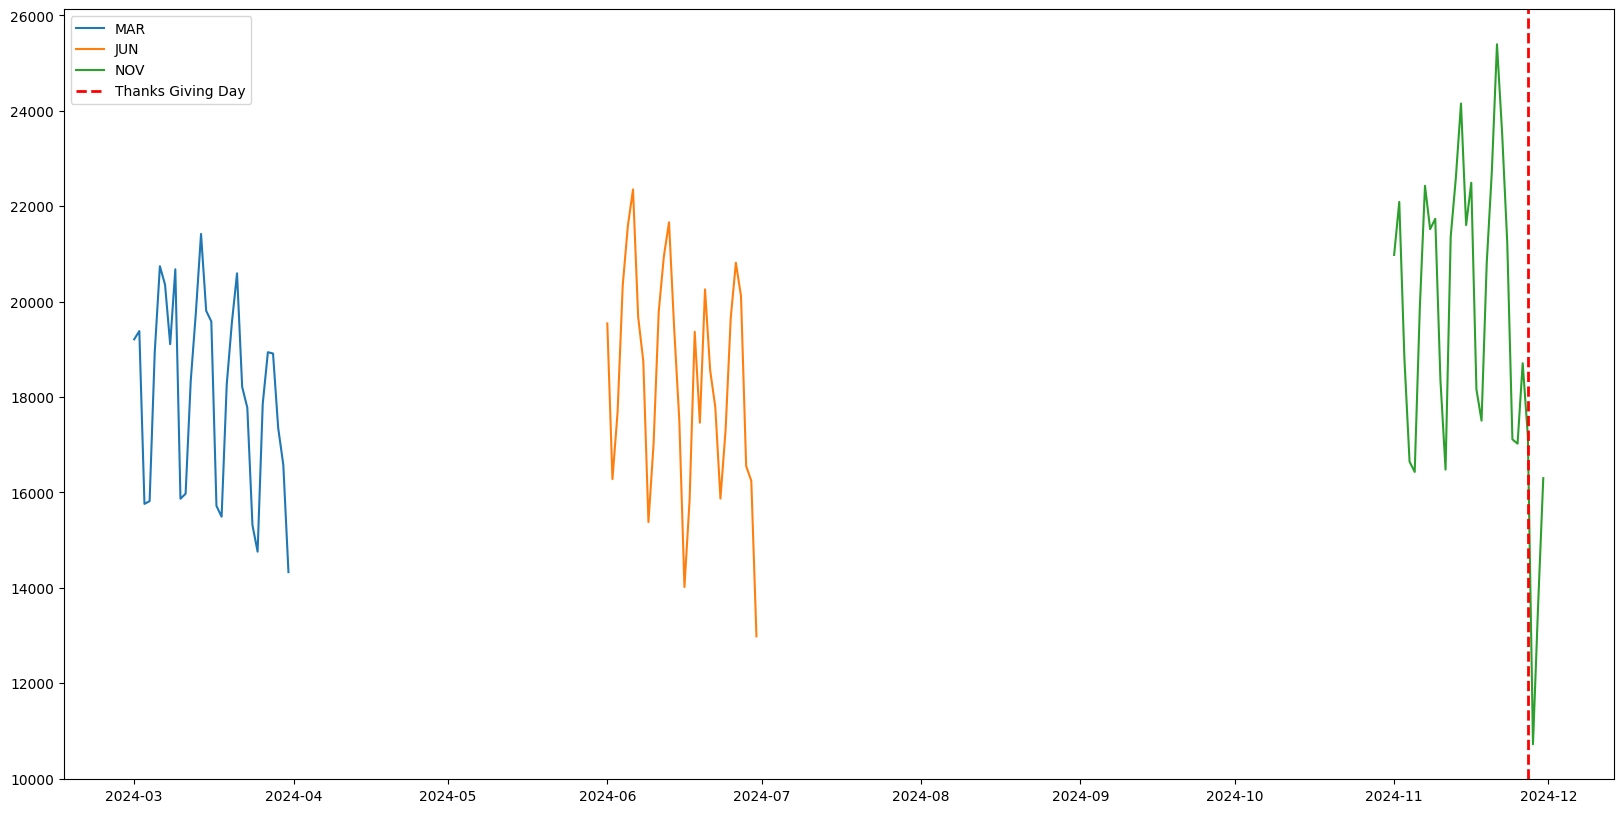

In [82]:
fig,ax = plt.subplots(figsize=(20,10))

start_date = '2024-03-01'
end_date = '2024-04-01'
march_df = df.query('@start_date<=pu_date<@end_date')
ax.plot(march_df['pu_date'],march_df['count'],label='MAR')


start_date = '2024-06-01'
end_date = '2024-07-01'
jan_df = df.query('@start_date<=pu_date<@end_date')
ax.plot(jan_df['pu_date'],jan_df['count'],label='JUN')

start_date = '2024-11-01'
end_date = '2024-12-01'
nov_df = df.query('@start_date<=pu_date<@end_date')
ax.plot(nov_df['pu_date'],nov_df['count'],label='NOV')


specific_date = pd.to_datetime('2024-11-27')
ax.axvline(x=specific_date, color='r', linestyle='--', linewidth=2,label='Thanks Giving Day')
plt.legend()
plt.show()

fig.savefig('outputs/images/temporal_distribution.png')

## Spatial regression 

In [663]:
from sklearn.preprocessing import FunctionTransformer
from spreg import ML_Lag

taxi_df.compute_taxi_zones()

coordsDict = dict(zip(taxi_df.taxi_zones['PULocationID'],list(zip(long,lat))))

groupedDf = clean_df.groupby(['PULocationID','DOLocationID','set_tip_amount_flag','pickup_time','dropoff_time'])[['fare_amount','tip_amount']].mean().reset_index()
groupedDf['PUCoords']=groupedDf['PULocationID'].apply(lambda x:coordsDict[x] if x in coordsDict.keys() else None)
groupedDf[['PULong','PULat']]=pd.DataFrame(groupedDf['PUCoords'].tolist())
groupedDf=groupedDf.dropna()

groupedDf['DOCoords']=groupedDf['DOLocationID'].apply(lambda x:coordsDict[x] if x in coordsDict.keys() else None)
groupedDf[['DOLong','DOLat']]=pd.DataFrame(groupedDf['PUCoords'].tolist())
groupedDf=groupedDf.dropna()


coords = groupedDf[['PULong', 'PULat']].values
w = KNN.from_array(coords, k=5)

# Encode hour as Fourier series
groupedDf['pu_hour_sin'] = np.sin(2 * np.pi * groupedDf['pu_hour'] / 24)
groupedDf['pu_hour_cos'] = np.cos(2 * np.pi * groupedDf['pu_hour'] / 24)

y = groupedDf['set_tip_amount_flag']
X = groupedDf[['fare_amount','pu_hour_sin','pu_hour_cos']]

model = ML_Lag(y, X, w=w)

# View summary
print(model.summary)

## Classification problem structure

It might be possible to work on a pipeline of two models where the first one classifies if the trip would be more propable to have a set amount regardless the total fare amount and the ones that have a percentage 

In [604]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,f1_score

model = xgb.XGBClassifier()
model.fit(X[:-4637], y[:-4637])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [606]:

X_valid = X[-4637:]
y_valid = y[-4637:]
pred = model.predict(X_valid)

accuracy = f1_score(pred,y_valid)
print(accuracy)

0.6270767055496642


In [607]:
accuracy_score(pred,y_valid)

0.5449644166486953

## Temporal analysis of the tip amount

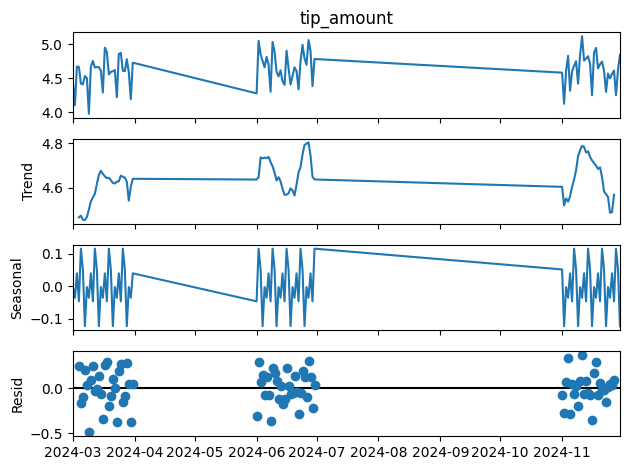

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
daily_tips = clean_df.groupby(clean_df['tpep_pickup_datetime'].dt.date)['tip_amount'].mean()

result = seasonal_decompose(daily_tips, model='additive', period=7)
result.plot()
plt.show()

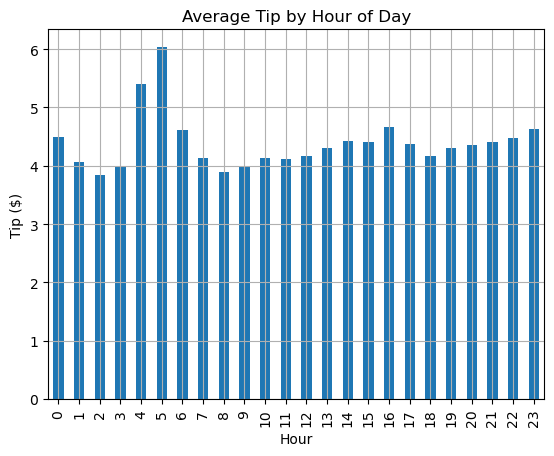

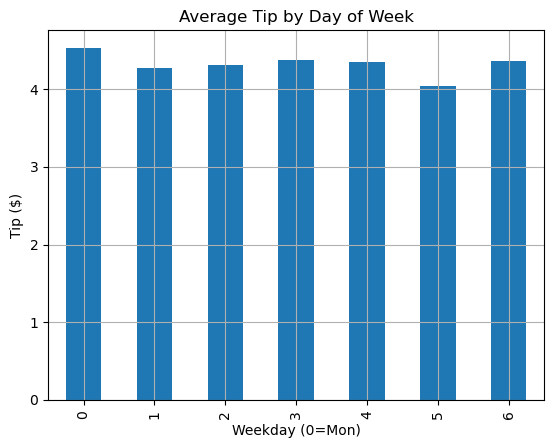

In [ ]:
# Hour of Day
hourly_avg = clean_df.groupby('pu_hour')['tip_amount'].mean()
hourly_avg.plot(kind='bar', title='Average Tip by Hour of Day')
plt.ylabel('Tip ($)')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

# Day of Week
weekday_avg = clean_df.groupby('pu_day')['tip_amount'].mean()
weekday_avg.plot(kind='bar', title='Average Tip by Day of Week')
plt.ylabel('Tip ($)')
plt.xlabel('Weekday (0=Mon)')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import spearmanr

# Convert dates to ordinal (numeric time)
time_numeric = clean_df['tpep_pickup_datetime'].map(pd.Timestamp.toordinal)
corr, pval = spearmanr(time_numeric, clean_df['tip_amount'])

print(f"Spearman Correlation: {corr:.4f}, p-value: {pval:.4e}")

Spearman Correlation: -0.0029, p-value: 1.4924e-05


In [ ]:
Q1 = clean_df['tip_to_fare'].quantile(0.25)
Q3 = clean_df['tip_to_fare'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Check how many values exceed the upper bound
print(f"Upper bound: {upper_bound}")
print((clean_df['tip_to_fare'] > upper_bound).mean())

# Filter based on IQR outlier threshold
clean_df = clean_df[clean_df['tip_to_fare'] <= upper_bound]

Upper bound: 0.4701778105539167
0.029458876636470604


## Establishing base lines

In [3]:
clean_df=pd.read_parquet('./data/clean_sample.parquet')

In [3]:

corr = clean_df[["tip_to_fare","tip_amount",'passenger_count',"trip_distance","fare_amount","duration_s",'Airport_flag','congestion_surcharge_flag','mta_tax_flag']].corr()
corr.style.background_gradient(cmap='coolwarm')

,tip_to_fare,tip_amount,passenger_count,trip_distance,fare_amount,duration_s,Airport_flag,congestion_surcharge_flag,mta_tax_flag
tip_to_fare,1.000000,0.078577,-0.005740,-0.170490,-0.277001,-0.121812,-0.109004,0.094406,0.058073
tip_amount,0.078577,1.000000,0.039687,0.606683,0.867011,0.288270,0.601041,-0.287771,-0.281754
passenger_count,-0.005740,0.039687,1.000000,0.027458,0.043376,0.024968,0.016800,-0.002099,-0.036001
trip_distance,-0.170490,0.606683,0.027458,1.000000,0.687364,0.226196,0.517914,-0.243923,-0.144400
fare_amount,-0.277001,0.867011,0.043376,0.687364,1.000000,0.327870,0.645451,-0.360140,-0.347990
duration_s,-0.121812,0.288270,0.024968,0.226196,0.327870,1.000000,0.207864,-0.074621,-0.042626
Airport_flag,-0.109004,0.601041,0.016800,0.517914,0.645451,0.207864,1.000000,-0.419893,-0.040894
congestion_surcharge_flag,0.094406,-0.287771,-0.002099,-0.243923,-0.360140,-0.074621,-0.419893,1.000000,0.310057
mta_tax_flag,0.058073,-0.281754,-0.036001,-0.144400,-0.347990,-0.042626,-0.040894,0.310057,1.000000


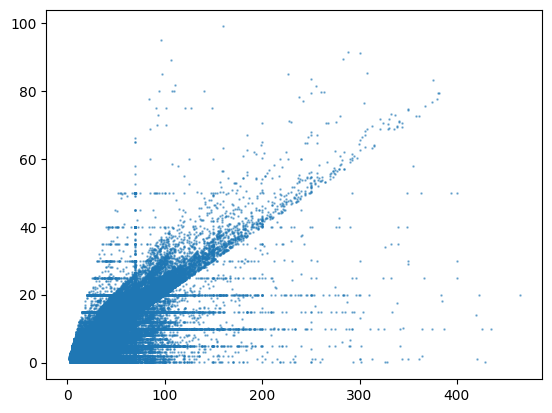

In [36]:
plt.scatter(clean_df['fare_amount'],clean_df['tip_amount'],s=0.6,alpha=0.5)

My first intuition looking the highly correlated values of tip amount and fare_amount,trip_distance is to try to fit a linear model on the data and see how it behaves. So first we will create a simple linear regression model that will be our base model. Did a test with fare amount and trip duration but the coefficient for the trip duration was extremly low. 

In [6]:
#split the df two to parts 


X=clean_df[["fare_amount",'Airport_flag','trip_distance','congestion_surcharge_flag','mta_tax_flag']]
y=clean_df[["tip_amount"]]


In [7]:

# 🪓 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:

# 📊 Baseline 1: Dummy Mean Regressor
mean_model = DummyRegressor(strategy="mean")
mean_model.fit(X_train, y_train)
y_pred_mean = mean_model.predict(X_test)

# 📊 Baseline 2: Dummy Median Regressor
median_model = DummyRegressor(strategy="median")
median_model.fit(X_train, y_train)
y_pred_median = median_model.predict(X_test)

# 📈 Baseline 3: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

# 🌳 Baseline 4: Simple Decision Tree
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)


# 🧾 Report
print("Model Evaluation:")
eval_model("Dummy Mean", y_test, y_pred_mean)
eval_model("Dummy Median", y_test, y_pred_median)
eval_model("Linear Regression", y_test, y_pred_linreg)
eval_model("Decision Tree", y_test, y_pred_tree)

2025/06/02 15:13:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '42ee0a8170b4475ca4910682fc2f8f67', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/02 15:13:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling 

🏃 View run luxuriant-squid-228 at: http://localhost:5000/#/experiments/0/runs/42ee0a8170b4475ca4910682fc2f8f67
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:13:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:13:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2e1c5dc9b68b4489b8f77a1a999

🏃 View run luxuriant-kite-348 at: http://localhost:5000/#/experiments/0/runs/2e1c5dc9b68b4489b8f77a1a999a2cd1
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:13:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:13:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5680dee7e30c4fb7acdc8a56c6e

🏃 View run aged-owl-835 at: http://localhost:5000/#/experiments/0/runs/5680dee7e30c4fb7acdc8a56c6e4bf52
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:13:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:13:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2739aa8087c2452d9baea6b3741

🏃 View run agreeable-skunk-147 at: http://localhost:5000/#/experiments/0/runs/2739aa8087c2452d9baea6b37410f56d
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:14:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Model Evaluation:
Dummy Mean           | MSE: 15.6497 | R²: -0.0000
Dummy Median         | MSE: 17.0848 | R²: -0.0917
Linear Regression    | MSE: 5.7565 | R²: 0.6322
Decision Tree        | MSE: 4.0166 | R²: 0.7433


From our first experiment, we can observe that we can achieve good results in MSE and R² with LR and DT to achieve very similar results,which can be verified also with some additional cross validation.

In [23]:

coef =linreg.coef_[0]
for idx,name in enumerate(X_test.columns):
    
    print(f"{name:<20} | coef: {coef[idx]:.4f} ")

fare_amount          | coef: 0.1937 


In [47]:
print(cross_val_score(linreg, X, y, scoring='r2', cv=5))
print(cross_val_score(tree, X, y, scoring='r2', cv=5))

2025/06/02 15:14:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '28365b19b5644e838065a8d943227393', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/02 15:14:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling 

🏃 View run nebulous-stoat-640 at: http://localhost:5000/#/experiments/0/runs/28365b19b5644e838065a8d943227393
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:14:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:14:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a15fdf0cd0fe452fa2382b19fe7

🏃 View run melodic-midge-173 at: http://localhost:5000/#/experiments/0/runs/a15fdf0cd0fe452fa2382b19fe7592a1
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:14:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:14:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2fa5e36b862a4c9991b7b0d1e07

🏃 View run orderly-lamb-37 at: http://localhost:5000/#/experiments/0/runs/2fa5e36b862a4c9991b7b0d1e07cff79
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:14:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:14:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8671cc77b14f452589cbfbe3008

🏃 View run sincere-dolphin-432 at: http://localhost:5000/#/experiments/0/runs/8671cc77b14f452589cbfbe3008c2b34
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:14:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:14:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'de3dbdc1f05b4fcf8ebd3336c17

🏃 View run clumsy-chimp-594 at: http://localhost:5000/#/experiments/0/runs/de3dbdc1f05b4fcf8ebd3336c17c103c
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:14:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:14:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4dd53e43190c42779bed8fd60d4

[0.63564567 0.63496978 0.62955444 0.63106375 0.63118467]


2025/06/02 15:14:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:14:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/wo

🏃 View run treasured-jay-550 at: http://localhost:5000/#/experiments/0/runs/4dd53e43190c42779bed8fd60d476eda
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:14:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:14:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e3abc42cd8864fa68314e87c652

🏃 View run handsome-crow-45 at: http://localhost:5000/#/experiments/0/runs/e3abc42cd8864fa68314e87c6523c99a
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:14:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:14:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c63685888b0a43a996d9a51a0c3

🏃 View run peaceful-moth-147 at: http://localhost:5000/#/experiments/0/runs/c63685888b0a43a996d9a51a0c3f4325
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:14:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:14:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '21d8a78e22784ad7aa1beb757e1

🏃 View run skittish-shrike-344 at: http://localhost:5000/#/experiments/0/runs/21d8a78e22784ad7aa1beb757e1e9b01
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:15:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:15:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'df432b60c7df4083b2b905aa819

🏃 View run stately-gnat-824 at: http://localhost:5000/#/experiments/0/runs/df432b60c7df4083b2b905aa8194da9a
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:15:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


[0.74743263 0.74485526 0.74212812 0.73945265 0.74027177]


(array([7.00000e+00, 1.40000e+01, 7.90000e+01, 5.93400e+03, 3.50094e+05,
        8.60000e+02, 4.10000e+01, 4.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-55.64417599, -42.89186864, -30.13956129, -17.38725393,
         -4.63494658,   8.11736077,  20.86966813,  33.62197548,
         46.37428283,  59.12659018,  71.87889754]),
 <BarContainer object of 10 artists>)

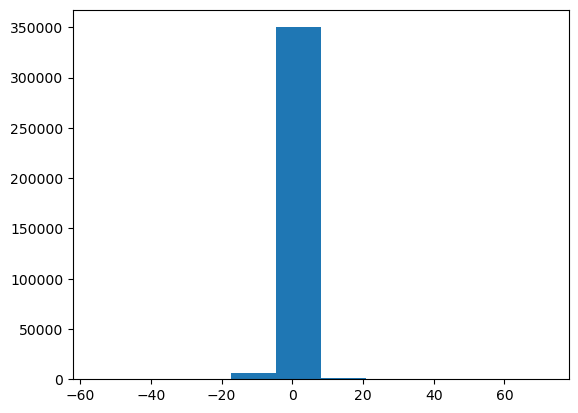

In [78]:
plt.hist(residuals)

Plotting the residuals over the fitted values we can obeserve that our model suffers from heteroscedacity

### Log Transform the target

In [48]:
# Log transform 
linregLog = LinearRegression()
linregLog.fit(X_train, np.log(y_train))
y_pred_linregLog = linregLog.predict(X_test)

eval_model("Linear Regression with Log transformation", np.log(y_test), y_pred_linregLog)


2025/06/02 15:15:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '38869e4c30554b08a8ab4737233dbca6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/02 15:16:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling 

🏃 View run glamorous-croc-842 at: http://localhost:5000/#/experiments/0/runs/38869e4c30554b08a8ab4737233dbca6
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:16:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Linear Regression with Log transformation | MSE: 0.2425 | R²: 0.5250


### Weighted Least Squares

WLS                  | MSE: 6.6788 | R²: 0.5732


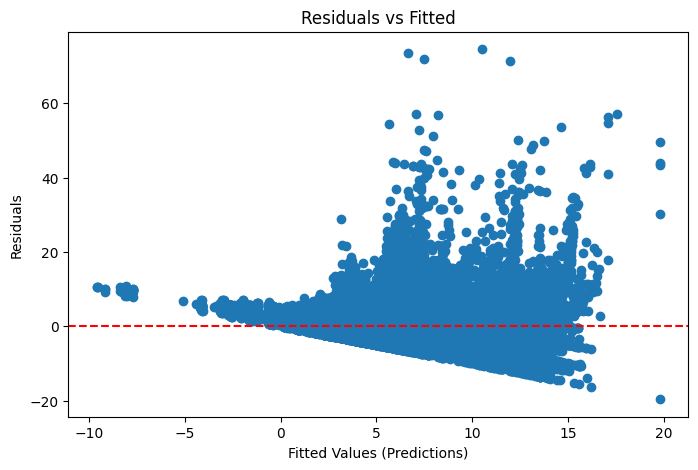

In [49]:
import statsmodels.api as sm

# Estimate variance from residuals of OLS
ols_resid = sm.OLS(y, X).fit().resid
weights = 1 / (ols_resid**2 + 1e-6)  # avoid division by zero

model_wls = sm.WLS(y, X, weights=weights).fit()
y_pred_wls = model_wls.predict(X_test)
eval_model("WLS ", y_test, y_pred_wls)


residuals = y_test['tip_amount'] - y_pred_wls.values.flatten()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_wls, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

## Regularisation

We can try apply regularisation on the regression model in case the hetersoscedacity is caused by multicollinearity of the predictors

In [38]:


from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# Intlize Power Transformer
qt = QuantileTransformer(output_distribution='normal')

# Numerical Columsn to Transform 
cols_num = ['trip_distance', 'fare_amount','total_amount']

# Fit and Transform
for col in cols_num:
    # Fit and transform
    clean_df[col] = qt.fit_transform(clean_df[[col]])

### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNetCV

# Automatically tune alpha and l1_ratio using cross-validation
elastic_net = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, 1], random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_elastic = elastic_net.predict(X_test)


In [10]:

# Evaluate
eval_model("Elastic Net", y_test, y_pred_elastic)

terms = [f"{coef:.4f}*{feature}" for feature, coef in zip(X_train.columns, elastic_net.coef_)]
equation = f"tip_amount = {elastic_net.intercept_:.4f} + " + " + ".join(terms)
print(equation)

Elastic Net          | MSE: 4.3846 | R²: 0.7198
tip_amount = 0.9210 + 0.1745*fare_amount + 0.0000*Airport_flag + 0.0801*trip_distance + 0.0000*congestion_surcharge_flag + 0.0000*mta_tax_flag


### Sequential Feature Selector

In [88]:
from sklearn.feature_selection import SequentialFeatureSelector

base_model = LinearRegression()

# Forward stepwise selection
sfs = SequentialFeatureSelector(base_model, direction='forward', n_features_to_select='auto', cv=5)
sfs.fit(X_train, y_train)

# Reduced feature set
selected_features = X_train.columns[sfs.get_support()]
print("Selected features:", list(selected_features))

# Fit final model on selected features
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

stepwise_model = LinearRegression()
stepwise_model.fit(X_train_reduced, y_train)
y_pred_stepwise = stepwise_model.predict(X_test_reduced)

# Evaluate
eval_model("Stepwise Linear", y_test, y_pred_stepwise)
terms = [f'{feature}*{coef:.4f}' for feature, coef in zip(selected_features, stepwise_model.coef_[0])]
equation = f"tip_amount = {stepwise_model.intercept_[0]:.4f} + " + " + ".join(terms)
print(equation)

Selected features: ['fare_amount', 'Airport_flag']
Stepwise Linear      | MSE: 3.4245 | R²: 0.7524
tip_amount = 1.0337 + fare_amount*0.1824 + Airport_flag*0.9078


## RandomForestRegressor

In [38]:
from sklearn.ensemble import RandomForestRegressor
clean_df=pd.read_parquet('./data/clean_sample.parquet')

rf = RandomForestRegressor(n_estimators=100, max_depth=10, max_features='sqrt')
rf.fit(X_train, y_train)
y_pred_rfr = rf.predict(X_test)
eval_model('RFRegressor',y_pred_rfr,y_test)

2025/06/02 16:46:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c4fc9c1df957439996531f967c17f958', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/02 16:46:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling 

🏃 View run burly-trout-49 at: http://localhost:5000/#/experiments/0/runs/c4fc9c1df957439996531f967c17f958
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 16:47:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


RFRegressor          | MSE: 1.5760 | R²: 0.8783


test the inclusion of the spatial encoded vectors

In [16]:
indices = np.arange(len(clean_df))

# 🪓 Train/Test split
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]

y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

In [20]:
x_train = np.concatenate((X_train,spatial_array[train_idx]),axis=0)

rf.fit(x_train, y_train)

x_test = np.concatenate((X_test,spatial_array[test_idx]),axis=1)

y_pred_rfr = rf.predict(x_test)
eval_model('RFRegressor',y_pred_rfr,y_test)

RFRegressor          | MSE: 4.6930 | R²: 0.1888


## HistGradientBoostingRegressor

In [39]:
from sklearn.ensemble import HistGradientBoostingRegressor


In [3]:
clean_df=pd.read_csv('./data/clean_sample.csv')

In [5]:
numerical_cols=['fare_amount','trip_distance','duration_s']


categorical_cols = ['RatecodeID', 
                    'store_and_fwd_flag',
                    'PULocationID', 
                    'DOLocationID',
                    'pu_day',
                    'pu_hour',
                    'Airport_flag',
                    'congestion_surcharge_flag',
                    'is_weekend',
                    'is_night',
                    'mta_tax_flag'
]

In [6]:
# No imputer here
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pass-through numerical features as-is (no imputation)
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

In [7]:
X=clean_df[numerical_cols+categorical_cols]
y=clean_df['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [40]:
pipe_hist = Pipeline([
    ('preprocess', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])


In [41]:

pipe_hist.fit(X_train, np.log(y_train))
y_pred_hist = pipe_hist.predict(X_test)

2025/06/02 16:48:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '65c5634bfcbc4c439f5b4ae92f534283', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/02 16:48:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling 

🏃 View run rumbling-jay-218 at: http://localhost:5000/#/experiments/0/runs/65c5634bfcbc4c439f5b4ae92f534283
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 16:48:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [17]:
# Evaluation metrics
mae = mean_absolute_error(np.log(y_test), y_pred_hist)
mse = mean_squared_error(np.log(y_test), y_pred_hist)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(y_test), y_pred_hist)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


MAE: 0.297
MSE: 0.217
RMSE: 0.466
R²: 0.544


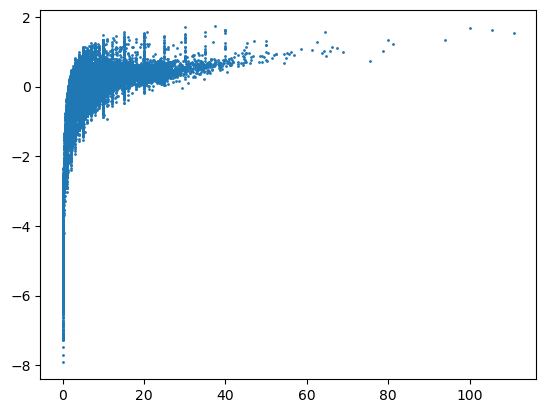

In [19]:
plt.scatter(y_test, np.log(y_test)-y_pred_hist,s=1)

In [23]:
catBoost

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['pu_day', 'pu_hour',
                                                   'Airport_flag',
                                                   'congestion_surcharge_flag',
                                                   'is_weekend', 'is_night',
                                                   'mta_tax_flag']),
                                                 ('num', 'passthrough',
                                                  ['fare_amount',
                                                   'trip_distance',
                                                   'total_amount', 'extra',
                                                   'tolls_amount'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7d6c3f05b710>)])

In [31]:
import shap


# 2. Extract the trained preprocessor and regressor
preprocessor = catBoost.named_steps['preprocess']
regressor = catBoost.named_steps['model']

# 3. Transform the input features for SHAP
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# 4. Use SHAP TreeExplainer on the final estimator
explainer = shap.Explainer(regressor, X_train_transformed[0:1000])


In [32]:
shap_values = explainer(X_test_transformed,check_additivity=False)


100%|===================| 339494/339772 [08:45<00:00]        

In [36]:
ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)

feature_names = list(encoded_cat_cols) + numerical_cols


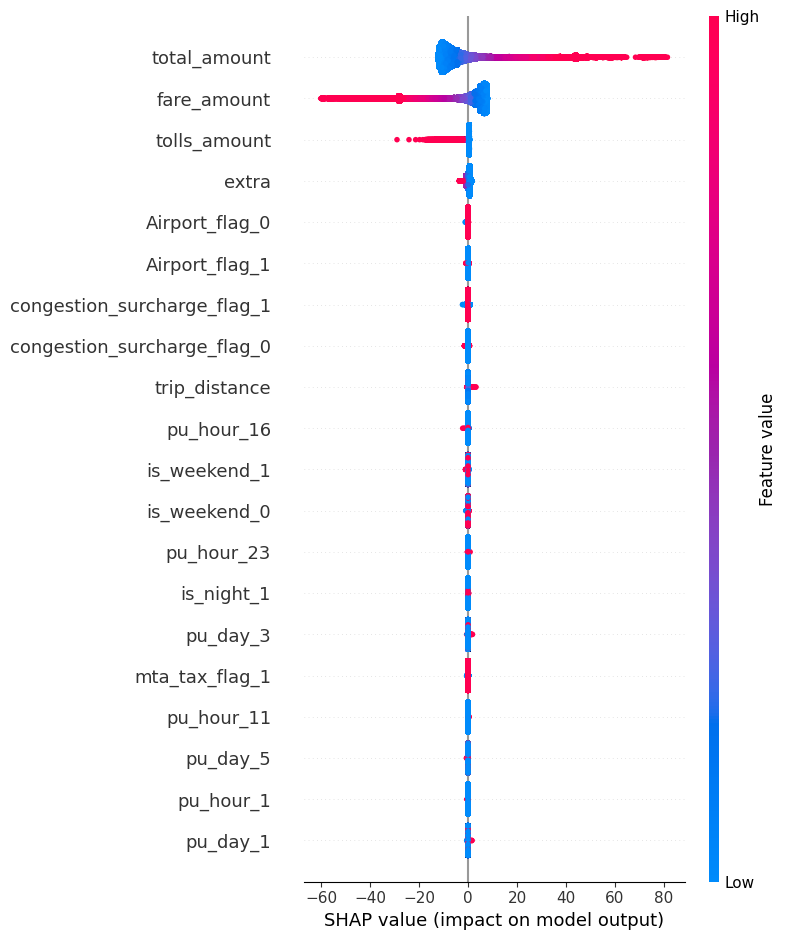

In [37]:

# 5. Visualize
shap.summary_plot(shap_values, X_test_transformed,feature_names=feature_names)

## XGBOOST

In [32]:
from xgboost import XGBRegressor

pipe_xgb = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        tree_method='hist'
    ))
])

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)

In [33]:
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


MAE: 0.998
MSE: 3.233
RMSE: 1.798
R²: 0.766


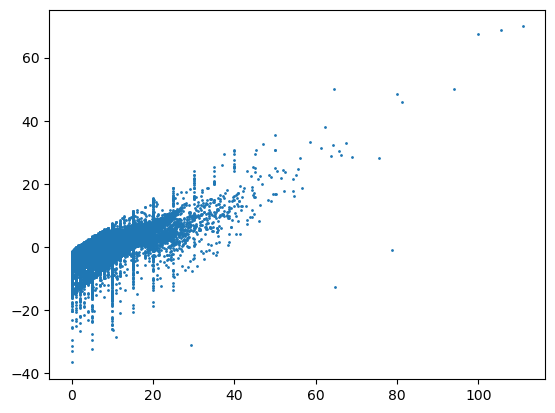

In [34]:
plt.scatter(y_test, y_test-y_pred_xgb,s=1)

## CatBoost

In [5]:
from catboost import CatBoostRegressor
clean_df=pd.read_parquet('./data/clean_sample.parquet')

In [3]:
# Power Transformer 
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

In [4]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
# Intlize Power Transformer
pt = PowerTransformer(standardize=True, method='yeo-johnson')

# Numerical Columsn to Transform
cols_num_pt = ['tolls_amount', 'extra']

# Fit and Transform
for col in cols_num_pt:
    # Fit and transform
    clean_df[col] = pt.fit_transform(clean_df[[col]])

# Intlize Power Transformer
qt = QuantileTransformer(output_distribution='normal')

# Numerical Columsn to Transform 
cols_num = ['trip_distance', 'fare_amount','total_amount']

# Fit and Transform
for col in cols_num:
    # Fit and transform
    clean_df[col] = qt.fit_transform(clean_df[[col]])
    

In [15]:
import seaborn as sns
# Paellete
palette = ['#8DECB4', '#41B06E', '#FFF5E0']

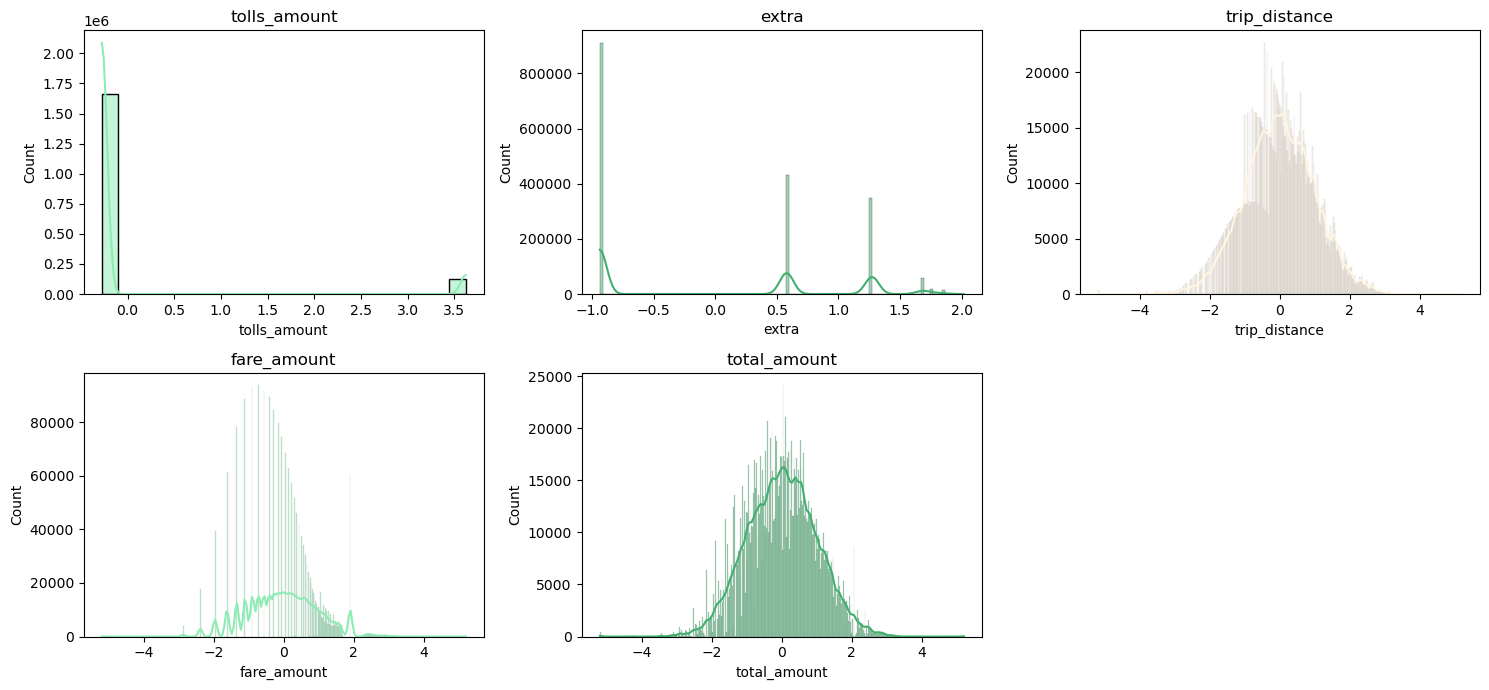

In [45]:
# Numerical columns to plot
cols_num = ['tolls_amount', 'extra', 'trip_distance', 'fare_amount', 'total_amount']

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each numerical column
for i, col in enumerate(cols_num):
    ax = axes[i]
    sns.histplot(clean_df[col], ax=ax, kde=True, color=palette[i % len(palette)])
    ax.set_title(col)  # Set title for each subplot

# Remove any remaining empty subplots
for i in range(len(cols_num), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

In [11]:
X

,fare_amount,Airport_flag,trip_distance,congestion_surcharge_flag,mta_tax_flag
2661989,7.9,0,1.30,1,1
1141272,10.7,0,0.99,1,1
2950867,8.6,0,0.72,1,1
365991,15.6,0,2.62,1,1
1763294,7.2,0,1.17,1,1
...,...,...,...,...,...
1490149,19.1,0,1.00,1,1
506845,10.7,0,1.13,1,1
201459,10.0,0,0.76,1,1
1825172,8.6,0,0.69,1,1


In [34]:
print(numerical_cols+categorical_cols)

['fare_amount', 'trip_distance', 'total_amount', 'extra', 'tolls_amount', 'pu_day', 'pu_hour', 'Airport_flag', 'congestion_surcharge_flag', 'is_weekend', 'is_night', 'mta_tax_flag']


In [10]:
numerical_cols=['fare_amount','trip_distance','total_amount','extra','tolls_amount']


categorical_cols = ['pu_day',
                    'pu_hour',
                    'Airport_flag',
                    'congestion_surcharge_flag',
                    'is_weekend',
                    'is_night',
                    'mta_tax_flag'
]

In [11]:

X=clean_df[numerical_cols+categorical_cols]
y=clean_df['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
# cat_params = {
#     'n_estimators': 100,
#     'learning_rate': 0.10899577626375372,
#     'depth': 7,
#     'colsample_bylevel': 0.7340962061535496,
#     'random_strength': 6.262882561405091,
#     'min_data_in_leaf': 92,
#     'verbose': 0
# } 

cat_params = {
    'iterations': 300,
    'learning_rate': 0.1,
    'depth': 4,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'verbose': 50,
    'early_stopping_rounds': 30,
    'random_seed': 42,
    'task_type': 'CPU',
    'one_hot_max_size': 2,
}

# No imputer here
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pass-through numerical features as-is (no imputation)
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

catBoost = Pipeline([
    ('preprocess', preprocessor),
    ('model', CatBoostRegressor(**cat_params))
])

catBoost.fit(X_train, y_train)
y_pred_xgb = catBoost.predict(X_test)


# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


2025/06/02 15:29:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1336d335e4674bbe919ec83be034cb84', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/06/02 15:29:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling 

0:	learn: 3.6599797	total: 23.3ms	remaining: 6.97s
50:	learn: 1.4534304	total: 1.21s	remaining: 5.91s
100:	learn: 1.3097278	total: 2.36s	remaining: 4.66s
150:	learn: 1.2058839	total: 3.52s	remaining: 3.47s
200:	learn: 1.1272601	total: 4.71s	remaining: 2.32s
250:	learn: 1.0671912	total: 5.82s	remaining: 1.14s
299:	learn: 1.0126136	total: 6.95s	remaining: 0us


2025/06/02 15:30:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/02 15:30:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to cond

🏃 View run selective-carp-682 at: http://localhost:5000/#/experiments/0/runs/1336d335e4674bbe919ec83be034cb84
🧪 View experiment at: http://localhost:5000/#/experiments/0


2025/06/02 15:30:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/itoumpalidis/work/git/nyc_taxi_tips/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


MAE: 0.474
MSE: 1.051
RMSE: 1.025
R²: 0.933


In [14]:
from joblib import dump, load

dump(catBoost, 'data/models/pipeline_model.joblib')


['data/models/pipeline_model.joblib']

In [ ]:
pipeline = load('pipeline_model.joblib')


In [30]:
feature_importance

array([0.00000000e+00, 1.31573677e-02, 5.48242628e-03, 2.54478701e-02,
       0.00000000e+00, 6.39967140e-03, 0.00000000e+00, 0.00000000e+00,
       5.79319075e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.77287184e-03, 0.00000000e+00, 0.00000000e+00,
       1.80759296e-03, 0.00000000e+00, 2.25137619e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.27578654e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.64576351e-03, 4.53751619e-03, 9.25114367e-03, 1.53631006e-01,
       1.80466554e-01, 1.02922687e-01, 2.00321070e-01, 1.92882388e-02,
       2.53813152e-02, 0.00000000e+00, 2.55779512e-03, 0.00000000e+00,
       4.67465848e-03, 1.75247834e+01, 1.20857059e-01, 7.63398610e+01,
       1.78860127e+00, 3.44534931e+00])

In [25]:
model = catBoost['model']

# Get feature importance
feature_importance = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Create a DataFrame to view the feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

print(feature_importance_df.sort_values(by='Importance', ascending=False))

ValueError: All arrays must be of the same length